In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/jkay/doad-strong-baseline/')

In [3]:
import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import verify_results
from detectron2.utils.events import EventStorage

from config import add_da_config
from trainer import DATrainer
import datasets # register Foggy Cityscapes
import rcnn # register DA R-CNN

import matplotlib.pyplot as plt

/home/jkay/miniconda3/envs/doad-strong/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def setup(args):
    """
    Copied directly from detectron2/tools/train_net.py
    """
    cfg = get_cfg()
    add_da_config(cfg)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

In [5]:
args = type('', (), {})()
args.config_file = '/home/jkay/doad-strong-baseline/configs/DA-RCNN-FPN-Cityscapes.yaml'
args.opts = []
cfg = setup(args)

[04/25 15:11:38 detectron2]: Rank of current process: 0. World size: 1
[04/25 15:11:39 detectron2]: Environment info:
-------------------------------  --------------------------------------------------------------------------------------------
sys.platform                     linux
Python                           3.9.16 (main, Mar  8 2023, 14:00:05) [GCC 11.2.0]
numpy                            1.24.2
detectron2                       0.7 @/home/jkay/doad-strong-baseline/libs/detectron2/detectron2
Compiler                         GCC 9.4
CUDA compiler                    CUDA 11.3
detectron2 arch flags            8.6
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.12.1+cu113 @/home/jkay/miniconda3/envs/doad-strong/lib/python3.9/site-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0,1                          NVIDIA RTX A5000 (arch=8.6)
Driver version                   515.

In [6]:
trainer = DATrainer(cfg)
trainer.resume_or_load(resume=False)

[04/25 15:11:40 d2.engine.defaults]: Model:
DARCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Seque

/home/jkay/miniconda3/envs/doad-strong/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: divide by zero encountered in union
  return lib.union(a, b, **kwargs)
/home/jkay/miniconda3/envs/doad-strong/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: divide by zero encountered in union
  return lib.union(a, b, **kwargs)
/home/jkay/miniconda3/envs/doad-strong/lib/python3.9/site-packages/shapely/set_operations.py:340: RuntimeWarning: divide by zero encountered in union
  return lib.union(a, b, **kwargs)


[04/25 15:11:48 d2.data.datasets.cityscapes]: Loaded 2975 images from datasets/cityscapes/leftImg8bit/train/
[04/25 15:11:48 d2.data.build]: Removed 10 images with no usable annotations. 2965 images left.
[04/25 15:11:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 832, 864, 896, 928, 960, 992, 1024), max_size=2048, sample_style='choice'), RandomFlip(), SaveImgAug(savename='img_weak'), <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7f29035104c0>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7f2903510a90>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7f2903510520>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7f2903510820>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7f2903510460>, <detectron2.data.transforms.augmentation_impl.RandomApply object at 0x7f2903510430>]
[04/25 15:11:48 d2.data.commo

In [38]:
trainer._trainer.data_loader.clear_prefetch()
with EventStorage(0) as trainer.storage:
    trainer.before_train()
    trainer.before_step()
    trainer.run_step()

In [39]:
labeled, unlabeled, pseudo = trainer._last_labeled, trainer._last_unlabeled_weak, trainer._last_pseudo

Text(0.5, 1.0, 'Pseudo')

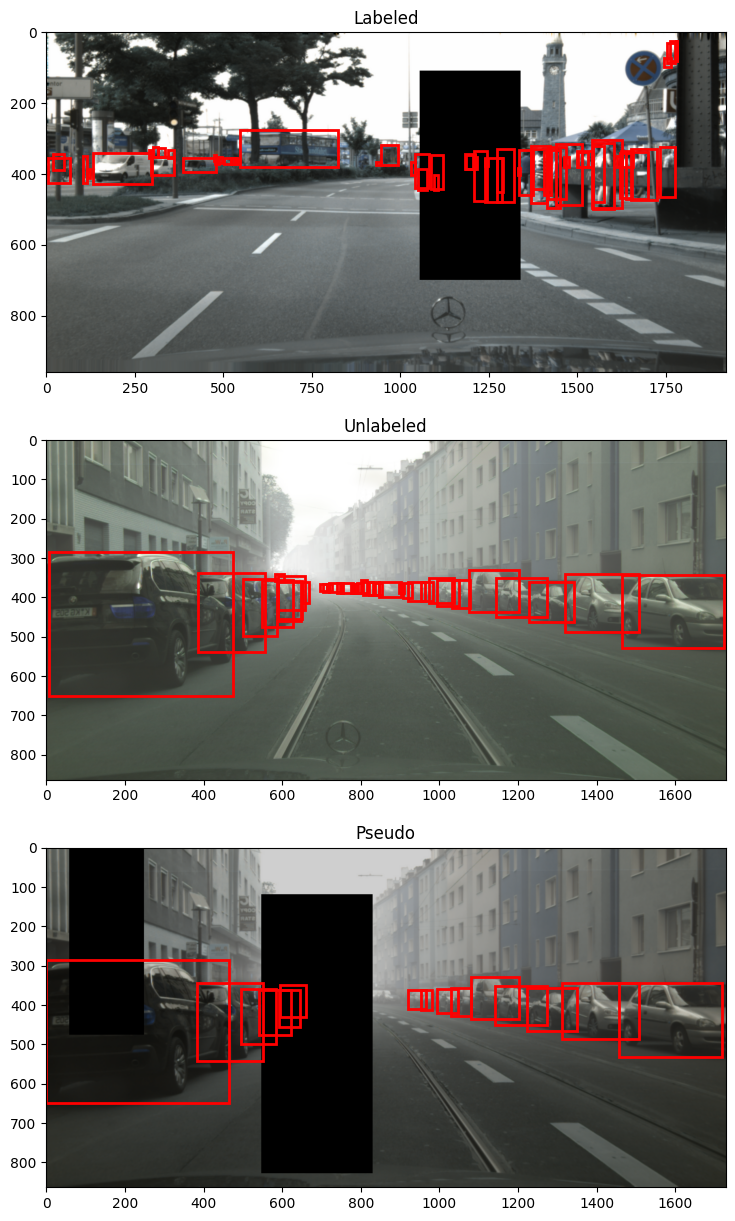

In [40]:
fig, ax = plt.subplots(3,1, figsize=(15,15))
labeled_im = labeled[0]['image'].permute(1,2,0).cpu().numpy()
unlabeled_im = unlabeled[0]['image'].permute(1,2,0).cpu().numpy()
pseudo_im = pseudo[0]['image'].permute(1,2,0).cpu().numpy()

# plot images
ax[0].imshow(labeled_im)
ax[1].imshow(unlabeled_im)
ax[2].imshow(pseudo_im)

# plot instances as rectangles
for inst in labeled[0]['instances'].gt_boxes.tensor:
    x1,y1,x2,y2 = inst.cpu().numpy()
    x1,y1,x2,y2 = int(x1),int(y1),int(x2),int(y2)
    ax[0].add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='r', linewidth=2))
for inst in unlabeled[0]['instances'].gt_boxes.tensor:
    x1,y1,x2,y2 = inst.cpu().numpy()
    ax[1].add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='r', linewidth=2))
for inst in pseudo[0]['instances'].gt_boxes.tensor:
    x1,y1,x2,y2 = inst.cpu().numpy()
    ax[2].add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, edgecolor='r', linewidth=2))

ax[0].set_title('Labeled')
ax[1].set_title('Unlabeled')
ax[2].set_title('Pseudo')